<a href="https://colab.research.google.com/github/sharmita01/gsoc_ml4sc_cern/blob/main/QCNN_elec_ph_clf_task3_Dey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##QCNN for electron-photon classification

In [2]:
!pip install tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 460kB 45.4MB/s 
     |████████████████████████████████| 20.1MB 11.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [1]:
!pip install tensorflow-quantum

     |████████████████████████████████| 5.9MB 9.6MB/s 
     |████████████████████████████████| 5.6MB 22.9MB/s 
     |████████████████████████████████| 1.6MB 49.9MB/s 
  Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1


Parts of the notebook are adapted from the examples by tfq

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [3]:
#mounting google drive
from google.colab import drive
import numpy as np
drive.mount("/content/drive")



Mounted at /content/drive


In [19]:
#load data from the drive
data = np.load('/content/drive/My Drive/Datasets/electron-photon.npz')

In [31]:
#inspect data
import matplotlib.pyplot as plt
train_data = data["x_train"]

photon = train_data[np.where(data["y_train"]==0)]
electron = train_data[np.where(data["y_train"]==1)]


In [32]:
import matplotlib.pyplot as plt

threshold = 0.0
x_train = data['x_train'][..., tf.newaxis]
y_train = data['y_train']
x_test = data['x_test'][..., tf.newaxis]/np.max(x_train)
y_test = data['y_test']
resize_shape = (100,4,4,1)
x_train_small = np.empty(resize_shape)
x_test_small = np.empty(resize_shape)

x_train_small_bin = np.empty(resize_shape)
x_test_small_bin = np.empty(resize_shape)

#reduce data dimension
for image in range(x_train.shape[0]):
  x_train_small[image] = tf.image.resize_with_crop_or_pad(x_train[image], 4,4).numpy()
for image in range(x_test.shape[0]):
  x_test_small[image] = tf.image.resize_with_crop_or_pad(x_test[image], 4,4).numpy()

x_train_small_scaled = tf.keras.utils.normalize(x_train_small, axis=-1, order=2)
x_test_small_scaled =  tf.keras.utils.normalize(x_test_small, axis=-1, order=2)                                                        #x_test_small/np.max(x_train_small)


#binary thresholding
for image in range(x_train.shape[0]):
  x_train_small_bin[image] = np.array(x_train_small[image] > threshold, dtype=np.float32)
for image in range(x_test.shape[0]):
  x_test_small_bin[image] = np.array(x_test_small[image] > threshold, dtype=np.float32)


[[1. 1. 1. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


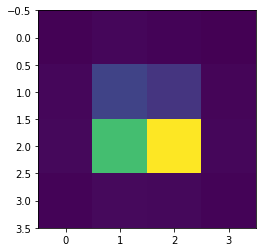

In [33]:
plt.imshow(x_train_small[9,:,:,0])

print(x_train_small_bin[0,:,:,0])

The qubits at pixel indices with values that exceed the threshold of 0.0, are rotated through an X  gate.

In [34]:
def to_circuit(data_):
    """Encode truncated classical image into quantum datapoint."""
    val = np.ndarray.flatten(data_)
    qubits = cirq.GridQubit.rect(1, 16)
    circuit = cirq.Circuit()
    for i, value in enumerate(val):
        if value:
            circuit.append(cirq.X(qubits[i]))
        
    return circuit


x_train_circ = [to_circuit(x) for x in x_train_small_bin]
x_test_circ = [to_circuit(x) for x in x_test_small_bin]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [35]:
print (x_train_tfcirc.shape)
print (y_train.shape)

(100,)
(100,)


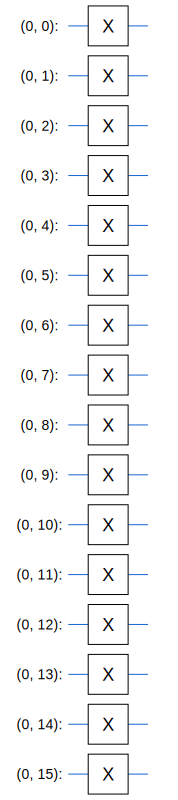

In [36]:
SVGCircuit(x_test_circ[0])

QCNN layers

In [37]:
def one_qubit_unitary(bit, symbols):
    """Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Cirq circuit for parameterized 'pooling', that
    reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

In [38]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits`.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

Quantum pooling

In [39]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """layer for a quantum pooling operation.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

Model

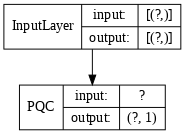

In [41]:
def create_model_circuit(qubits):
    """sequence of alternating convolution and pooling operators 
    """
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:84')
    
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[8:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[8:12], qubits[12:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[12:], symbols[42:57])
    model_circuit += quantum_pool_circuit(qubits[12:14], qubits[14:],
                                          symbols[57:63])
    model_circuit += quantum_conv_circuit(qubits[14:], symbols[63:78])
    model_circuit += quantum_pool_circuit(qubits[14:15], qubits[15:],
                                          symbols[78:84])
    return model_circuit


# qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 16)
readout_operators = cirq.Z(cluster_state_bits[-1])

input_ = tf.keras.Input(shape=(), dtype=tf.dtypes.string)


quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(input_)

qcnn_model = tf.keras.Model(inputs=[input_], outputs=[quantum_model])

# visualize model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

Model training

In [ ]:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else 0.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc,
                         y=y_train,
                         batch_size=32,
                         epochs=15,
                         verbose=1,
                         validation_data=(x_test_tfcirc, y_test))

In [43]:
#Validation accuracy from the last epoch
print (max(qcnn_model.history.history['val_custom_accuracy']))

0.578125


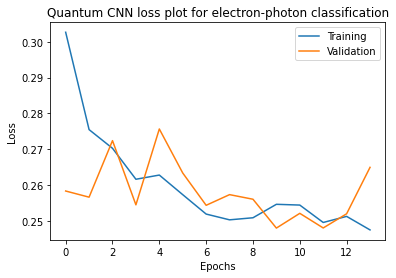

In [44]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Quantum CNN loss plot for electron-photon classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Hybrid quantum-classical networks

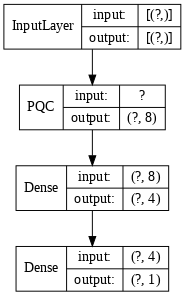

In [55]:


def multi_readout_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:8], qubits[8:],
                                          symbols[15:21])
    return model_circuit

cluster_state_bits = cirq.GridQubit.rect(1, 16)
readout_operators = [cirq.Z(bit) for bit in cluster_state_bits[8:]]

input_hybrid = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

#a single quantum convolution layer

quantum_model_hybrid = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readout_operators)(input_hybrid)

# classical dense layer 1
d1_ = tf.keras.layers.Dense(4)(quantum_model_hybrid)

# classical dense layer 2

d3_ = tf.keras.layers.Dense(1)(d1_)




hybrid_model = tf.keras.Model(inputs=[input_hybrid], outputs=[d3_])

# model structure
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [ ]:
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0.0 else 0.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = hybrid_model.fit(x=x_train_tfcirc,
                         y=y_train,
                         batch_size=32,
                         epochs=30,
                         verbose=1,
                         validation_data=(x_test_tfcirc, y_test))

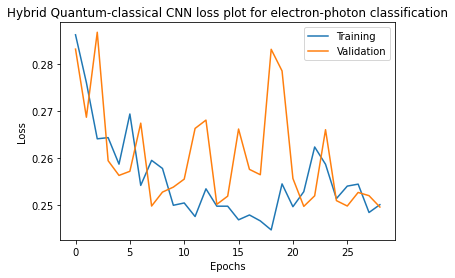

In [54]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Hybrid Quantum-classical CNN loss plot for electron-photon classification')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()